## Seasonality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
plt.style.use(['science','ieee'])
plt.rcParams['font.size'] = 13

def beta(t, beta_0, beta_1, phi):
    return beta_0 + beta_1*np.cos(np.pi*t/6 + phi)


def IER(t, beta_0, beta_1, phi, mu):
    return 1 - mu/beta(t, beta_0, beta_1, phi)

@np.vectorize
def CER(t, beta_0, beta_1, phi, mu):
    def _inner(s):
        return beta(s, beta_0, beta_1, phi) - mu
    
    def _outer(r):
        return mu*np.exp(-scipy.integrate.quad(_inner, t, r, limit=1000)[0])
    
    return 1/(1+scipy.integrate.quad(_outer, t, np.inf, limit=100)[0])

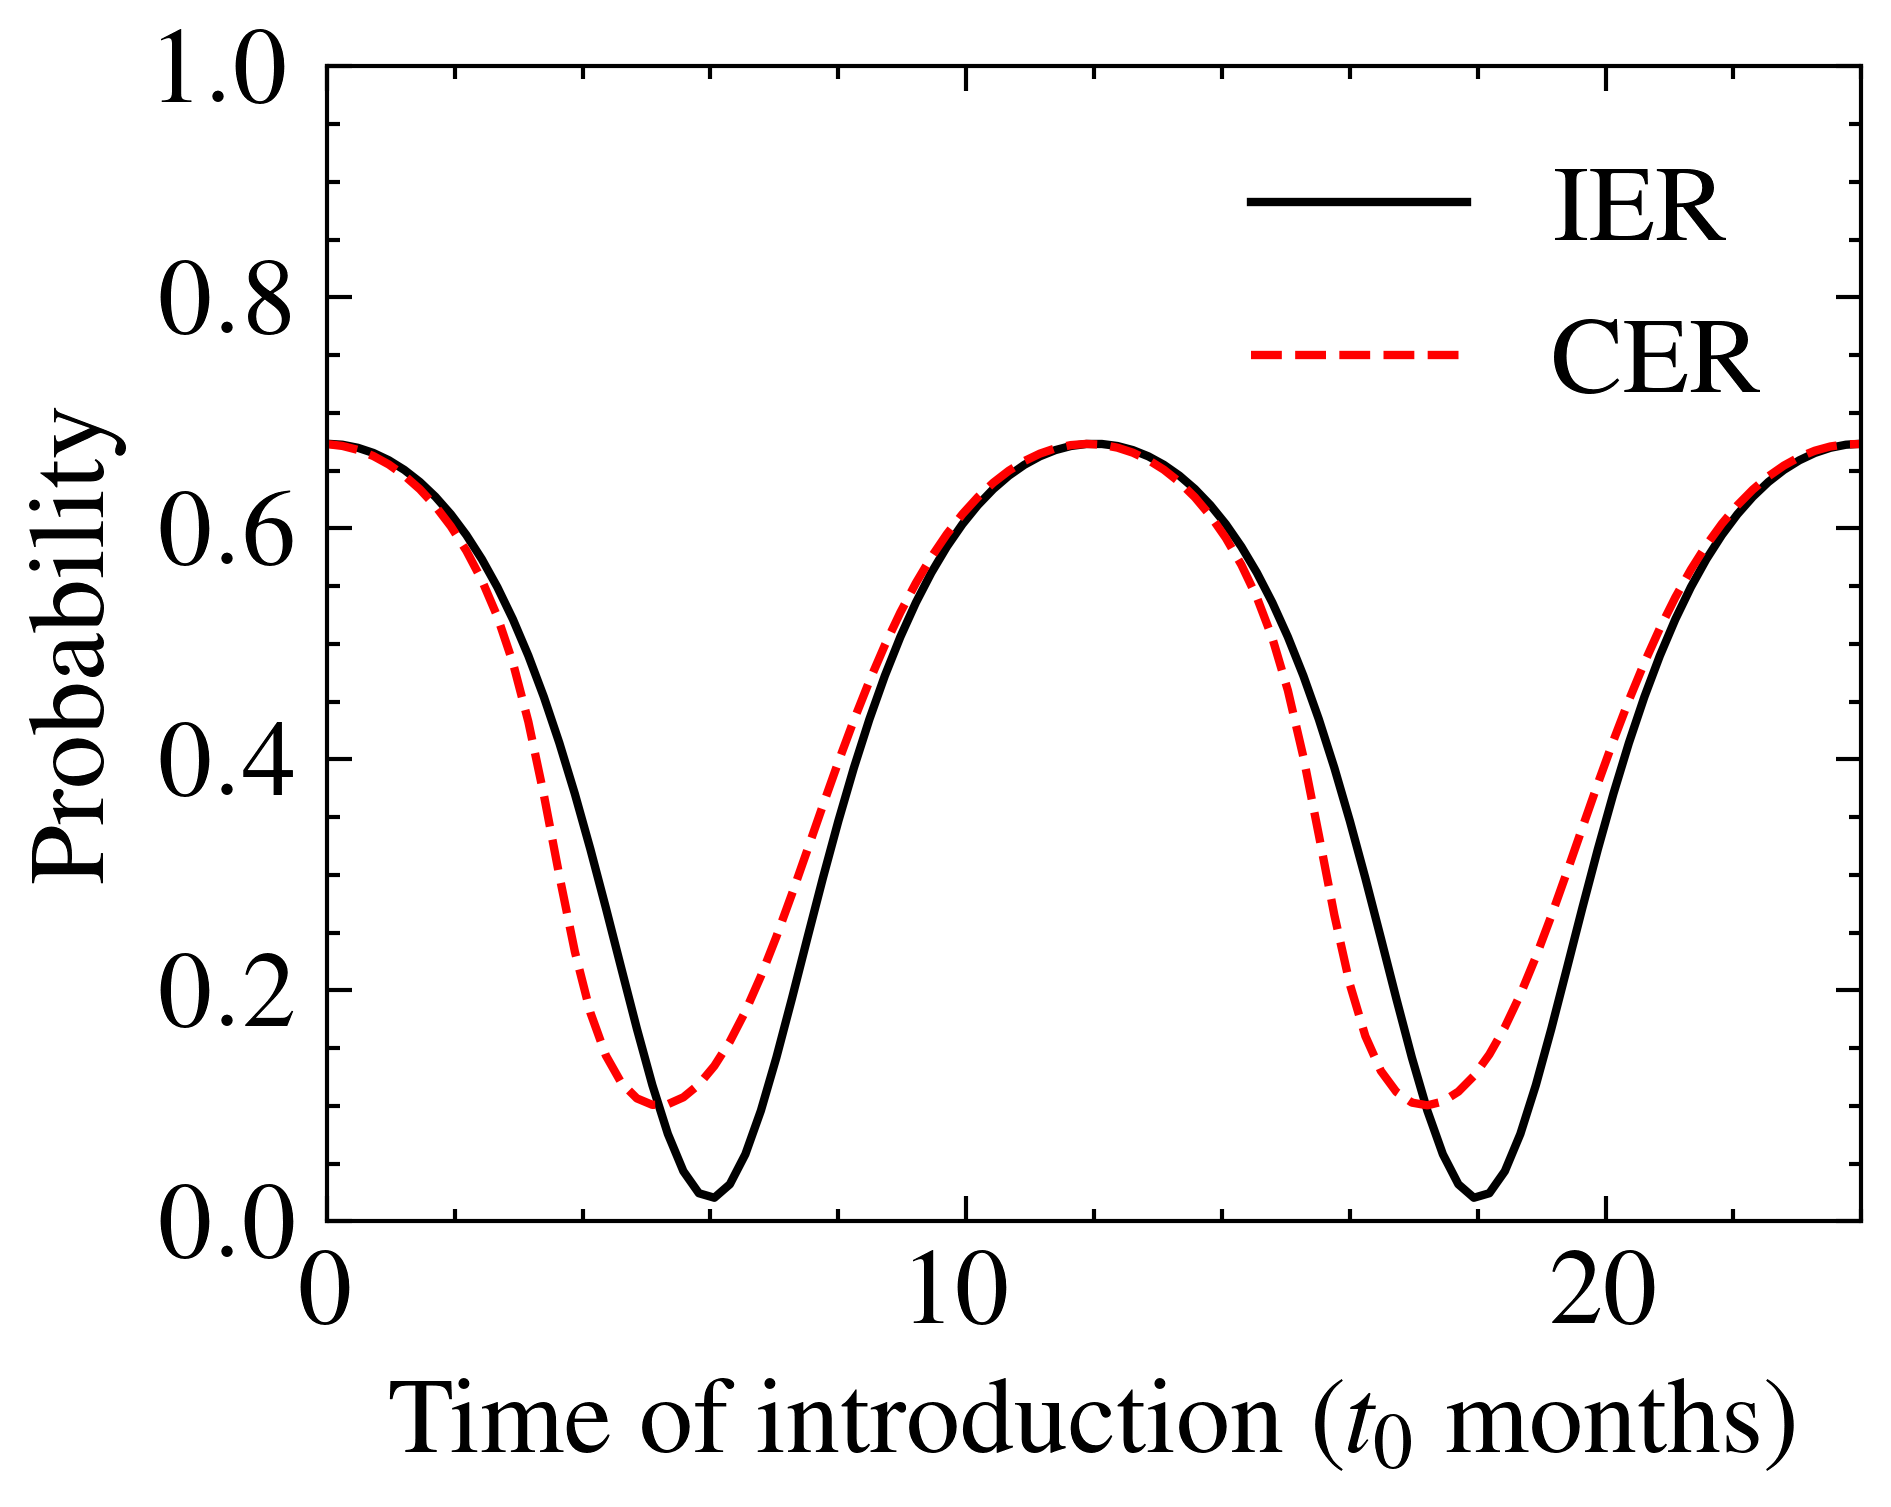

In [2]:
t = np.linspace(0, 24, 100)

N = 10_000
beta_0 = 10
beta_1 = 5
phi = 0
mu = 4.9

fig, ax = plt.subplots()
ax.plot(t, IER(t, beta_0, beta_1, phi, mu), label="IER")
ax.plot(t, CER(t, beta_0, beta_1, phi, mu), label="CER")
ax.set_xlabel("Time of introduction ($t_0$ months)")
ax.set_ylabel("Probability")
ax.legend(loc=1)
ax.set_xlim([0,24])
ax.set_ylim([0,1])
plt.savefig("figures/iercer.pdf")

100%|██████████| 10/10 [8:08:49<00:00, 2932.94s/it]  


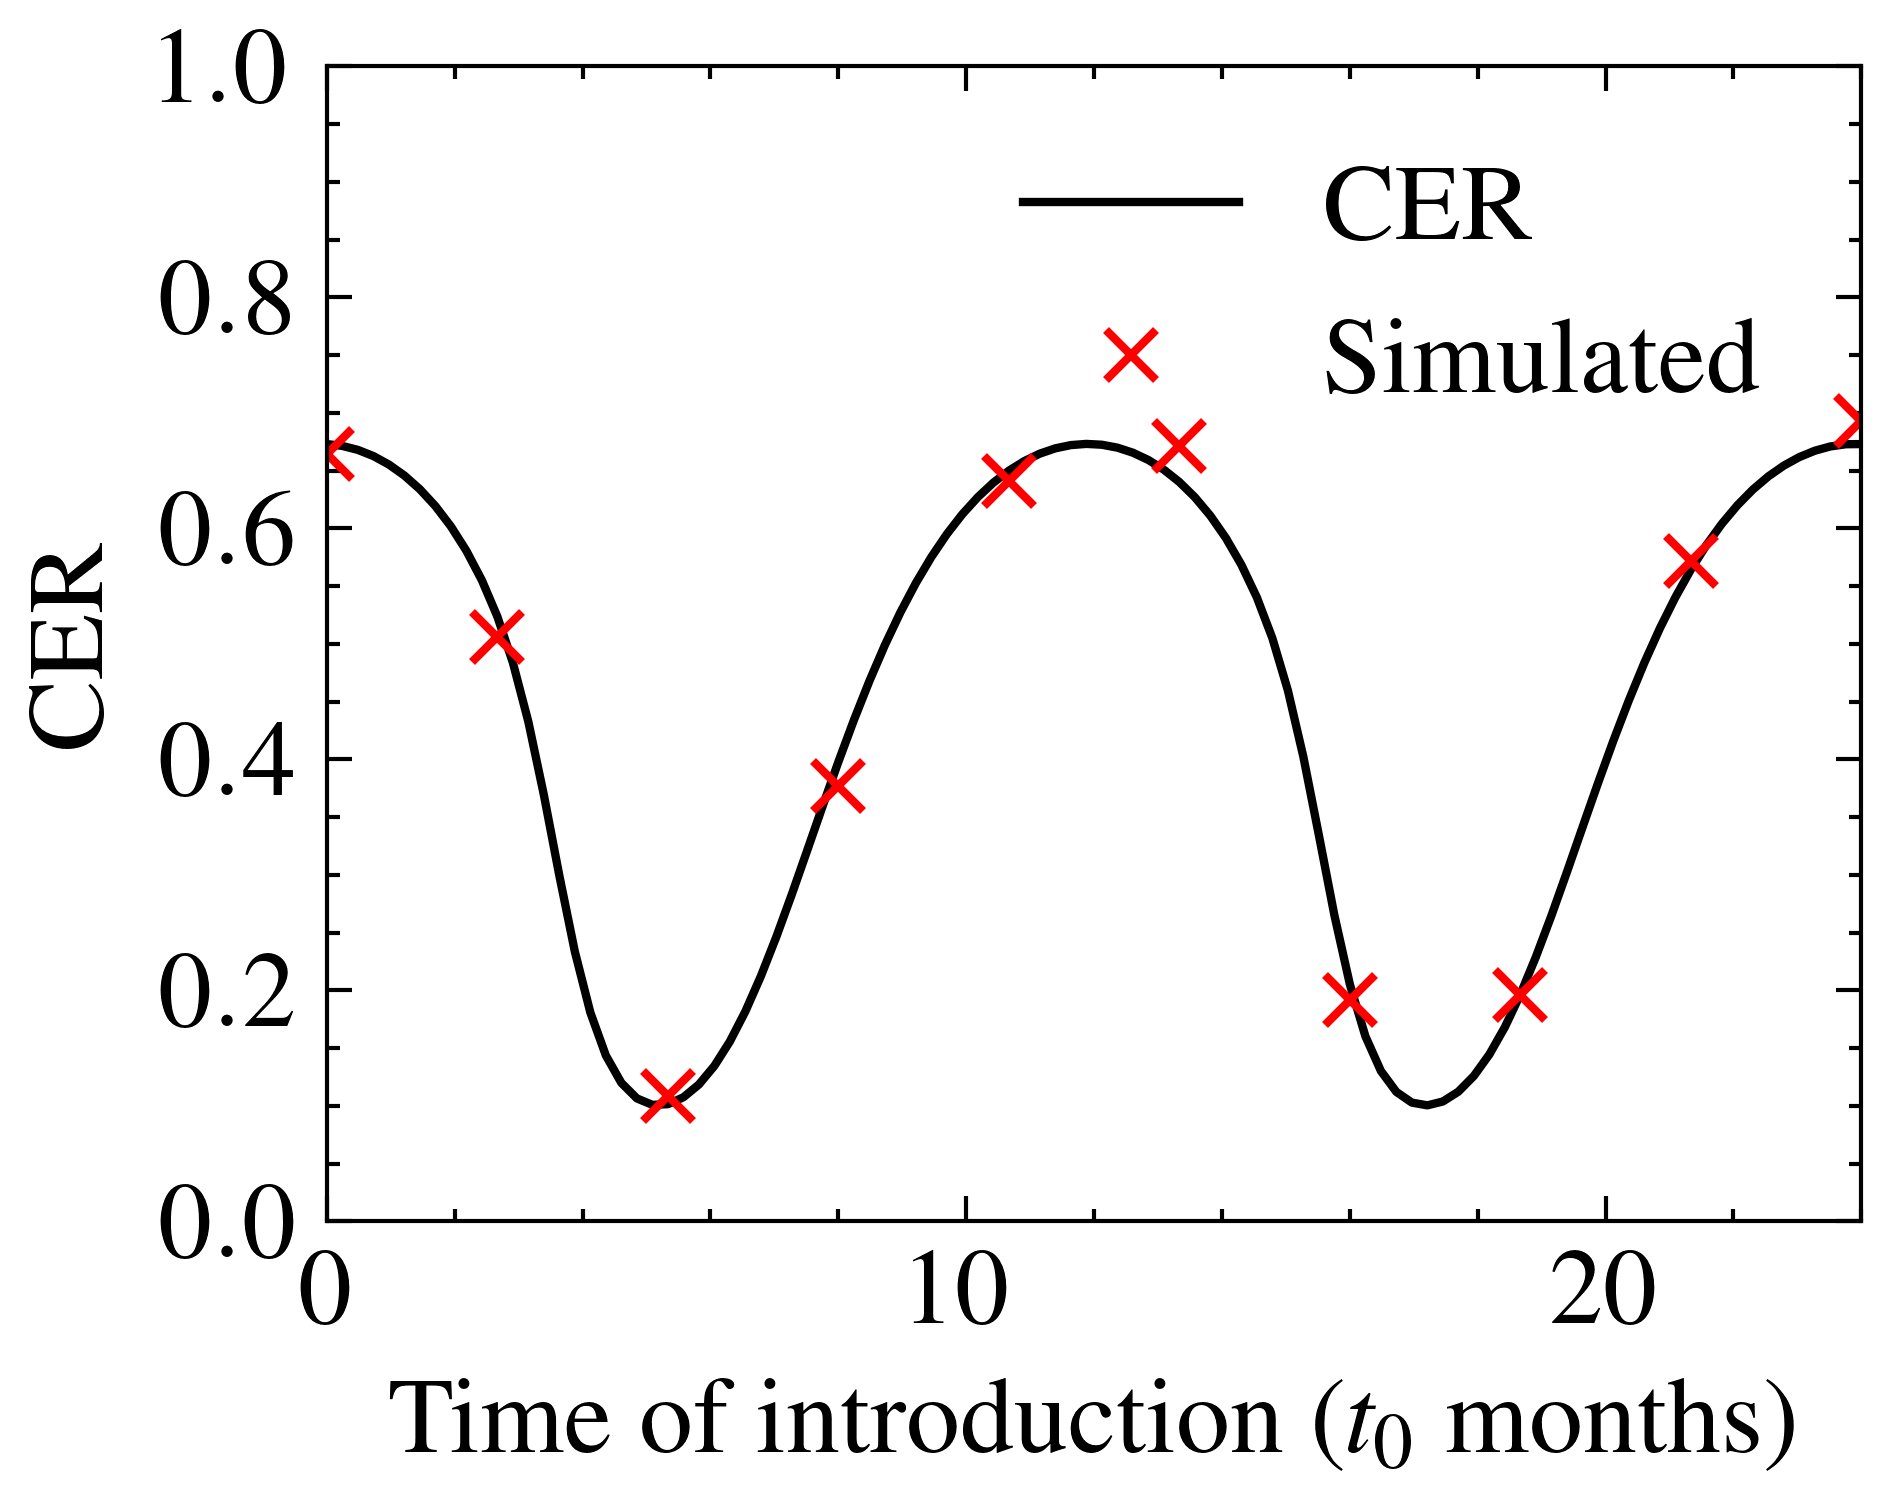

In [3]:
from bp_models.gillespie import direct_gillespie_sir_time_varying_beta

t0_sim = np.linspace(0, 24, 10)

simulated = []
num_sims = 1000

for t0 in tqdm(t0_sim):
    major_outbreaks = 0
    for _ in range(num_sims):
        _, _, infected = direct_gillespie_sir_time_varying_beta(t0, N, lambda t: beta(t, beta_0, beta_1, phi), mu)
        if infected > 0.2*N:
            major_outbreaks += 1
    simulated.append(major_outbreaks/num_sims)

fig, ax = plt.subplots()
ax.plot(t, CER(t, beta_0, beta_1, phi, mu), label="CER")
ax.plot(t0_sim, simulated, 'x', label="Simulated")
ax.set_xlabel("Time of introduction ($t_0$ months)")
ax.set_ylabel("CER")
ax.set_xlim([0,24])
ax.set_ylim([0,1])
ax.legend(loc=1)
plt.savefig("figures/CER_sim_vs_analytical.pdf")